## 전이학습
- 이미 학습된 모델을 가져옴
- 그 위에 새로운 분류기를 붙여서 내 데이터셋에 맞게 학습
- 전이학습에는 2가지 방식이 있음
  - **고정 학습 (Feature Extraction)**: 기존 모델의 가중치는 그대로 두고, 분류기만 학습
  - **미세 조정 (Fine-tuning)**: 기존 모델의 가중치도 일부/전체를 풀어서 내 데이터셋에 맞게 추가 학습

### 구성 요소
- **특징 추출기 (Feature Extractor)**: 이미지에서 일반적인 특징(엣지, 패턴 등)을 뽑음
- **분류기 (Classifier)**: 특징을 받아 최종 라벨을 결정
  - ex) 고양이/강아지 → 이진 분류  
  - ex) 딸기/사과/오렌지/포도 → 다중 분류

-> 지금은 고양이/강아지 이진 분류를 해야 하므로, 기존 특징 추출기는 고정하고, 분류기를 새로 학습해야 함

In [46]:
import os
import tensorflow as tf

In [47]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2025-09-01 04:55:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M  19.6MB/s    in 4.2s    

2025-09-01 04:55:35 (15.6 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [48]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
import os, tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

path = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')
train_dir = os.path.join(path, 'train')
val_dir   = os.path.join(path, 'validation')

batch_size = 200
img_size   = (160, 160)
seed       = 1337 # 섞는 순서를 동일하게

In [50]:
train_dataset = image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=batch_size, image_size=img_size, seed=seed # shuffle: 데이터 섞음->과적합 방지
)

val_full = image_dataset_from_directory(
    val_dir, shuffle=True, batch_size=batch_size, image_size=img_size, seed=seed
)

val_batch = tf.data.experimental.cardinality(val_full) # 전체 배치가 몇 개인지 구하기
test_dataset = val_full.take(val_batch // 5) # 20%
val_dataset = val_full.skip(val_batch // 5) # 80%

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [51]:
# 데이터 증강-반전/회전
data_aug   = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.35),
])

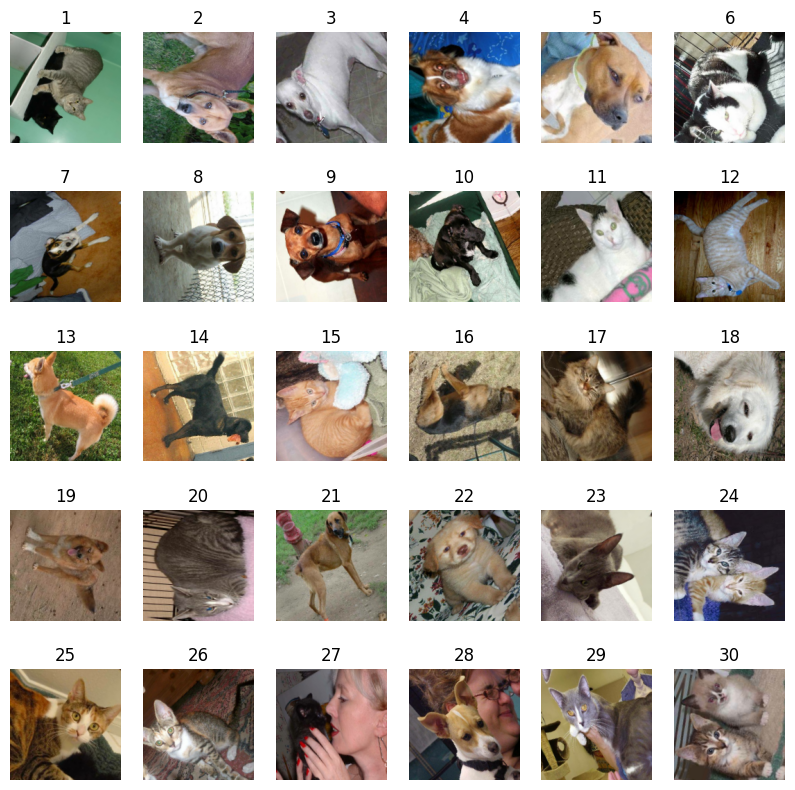

In [52]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)

        img = images[i].numpy().astype("uint8")
        aug_img = data_aug(tf.expand_dims(img, 0))
        aug_img = tf.squeeze(aug_img, axis=0).numpy().astype("uint8")

        plt.imshow(aug_img)
        plt.title(i+1)
        plt.axis("off")
    plt.show()

In [53]:
# 모델 구성
img_shape  = (160, 160, 3)

# MobileNetv2 불러오기
# - input_shape: 사용할 이미지 입력 크기
# - include_top=False: 원래 ImageNet 분류기 부분은 빼고 가져옴
# - weights='imagenet': ImageNet에서 학습된 가중치 사용 -> 나는 전이학습을 할거니까
base = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

base.trainable = False # 사전에 학습된 가중치 고정 -> 가중치 업뎃 안함(고정학습)

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input # 이미지는 원래 [0,255] 범위 -> MobileNetV2에 맞는 [-1,1] 범위로 변경

inputs = tf.keras.Input(shape=img_shape) # 모델의 입력 레이어 정의 -> 160x160, RGB 3채널

x = data_aug(inputs)
x = preprocess(x)
x = base(x, training=False) # 사전에 학습된 MobileNetV2의 특징 추출 but 학습되지 않게 고정
x = tf.keras.layers.GlobalAveragePooling2D()(x) # MobileNetV2 feature map은 보통 7x7x1280 형태로 큼 -> pooling해서 1280차원 벡터로 압축 -> 1차원
x = tf.keras.layers.Dropout(0.2)(x) # Dropout(0.2): 학습할 때 뉴런을 20% 확률로 끔 -> 과적합 방지
outputs = tf.keras.layers.Dense(1)(x) # Dense(1): 출력층 -> 이진분류 할거니까 노드 1개만 출력
model = tf.keras.Model(inputs, outputs)

base_lr = 1e-4 # 학습률

# 모델 컴파일
# - optimizzer: Adam (학습률 1e-4)
# - loss: BinaryCrossentropy(from_logits=True): 이진 분류 손실 함수, 출력층 Dense(1)에서 sigmoid 없이 login을 내므로 손실 함수에서 내부적으로 sigmoid 적용
# - metrics: 정확도
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Dense: 이 특징 벡터에서 강아지/고양이 중 어디에 더 가까운지 점수(logit) 만들어냄
### sigmoid: Dense가 출력한 점수를 0~1사이 확률로 변환, ex 강아지일 확률 70%

In [54]:
# 1단계: 고정학습 -> 기존 가중치는 그대로 두고 분류기만 학습
warm_epochs = 10
history = model.fit(train_dataset, epochs=warm_epochs, validation_data=val_dataset)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.3670 - loss: 1.0356 - val_accuracy: 0.4675 - val_loss: 0.8126
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.4149 - loss: 0.9555 - val_accuracy: 0.5088 - val_loss: 0.7530
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.4529 - loss: 0.8968 - val_accuracy: 0.5450 - val_loss: 0.7006
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.4784 - loss: 0.8493 - val_accuracy: 0.5950 - val_loss: 0.6401
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.5197 - loss: 0.7933 - val_accuracy: 0.6363 - val_loss: 0.5995
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - accuracy: 0.5636 - loss: 0.7372 - val_accuracy: 0.6538 - val_loss: 0.5567
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.5812 - loss: 0.7088 - val_accuracy: 0.7138 - val_loss: 0.5150
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.6211 - loss: 0.6472 - val_accuracy: 0

In [55]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8100 - loss: 0.4281
Test accuracy : 0.8100000023841858
<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Predictions:
 [1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0
 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1
 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0]
Labels:
 [1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1
 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0
 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0
 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1
 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0]


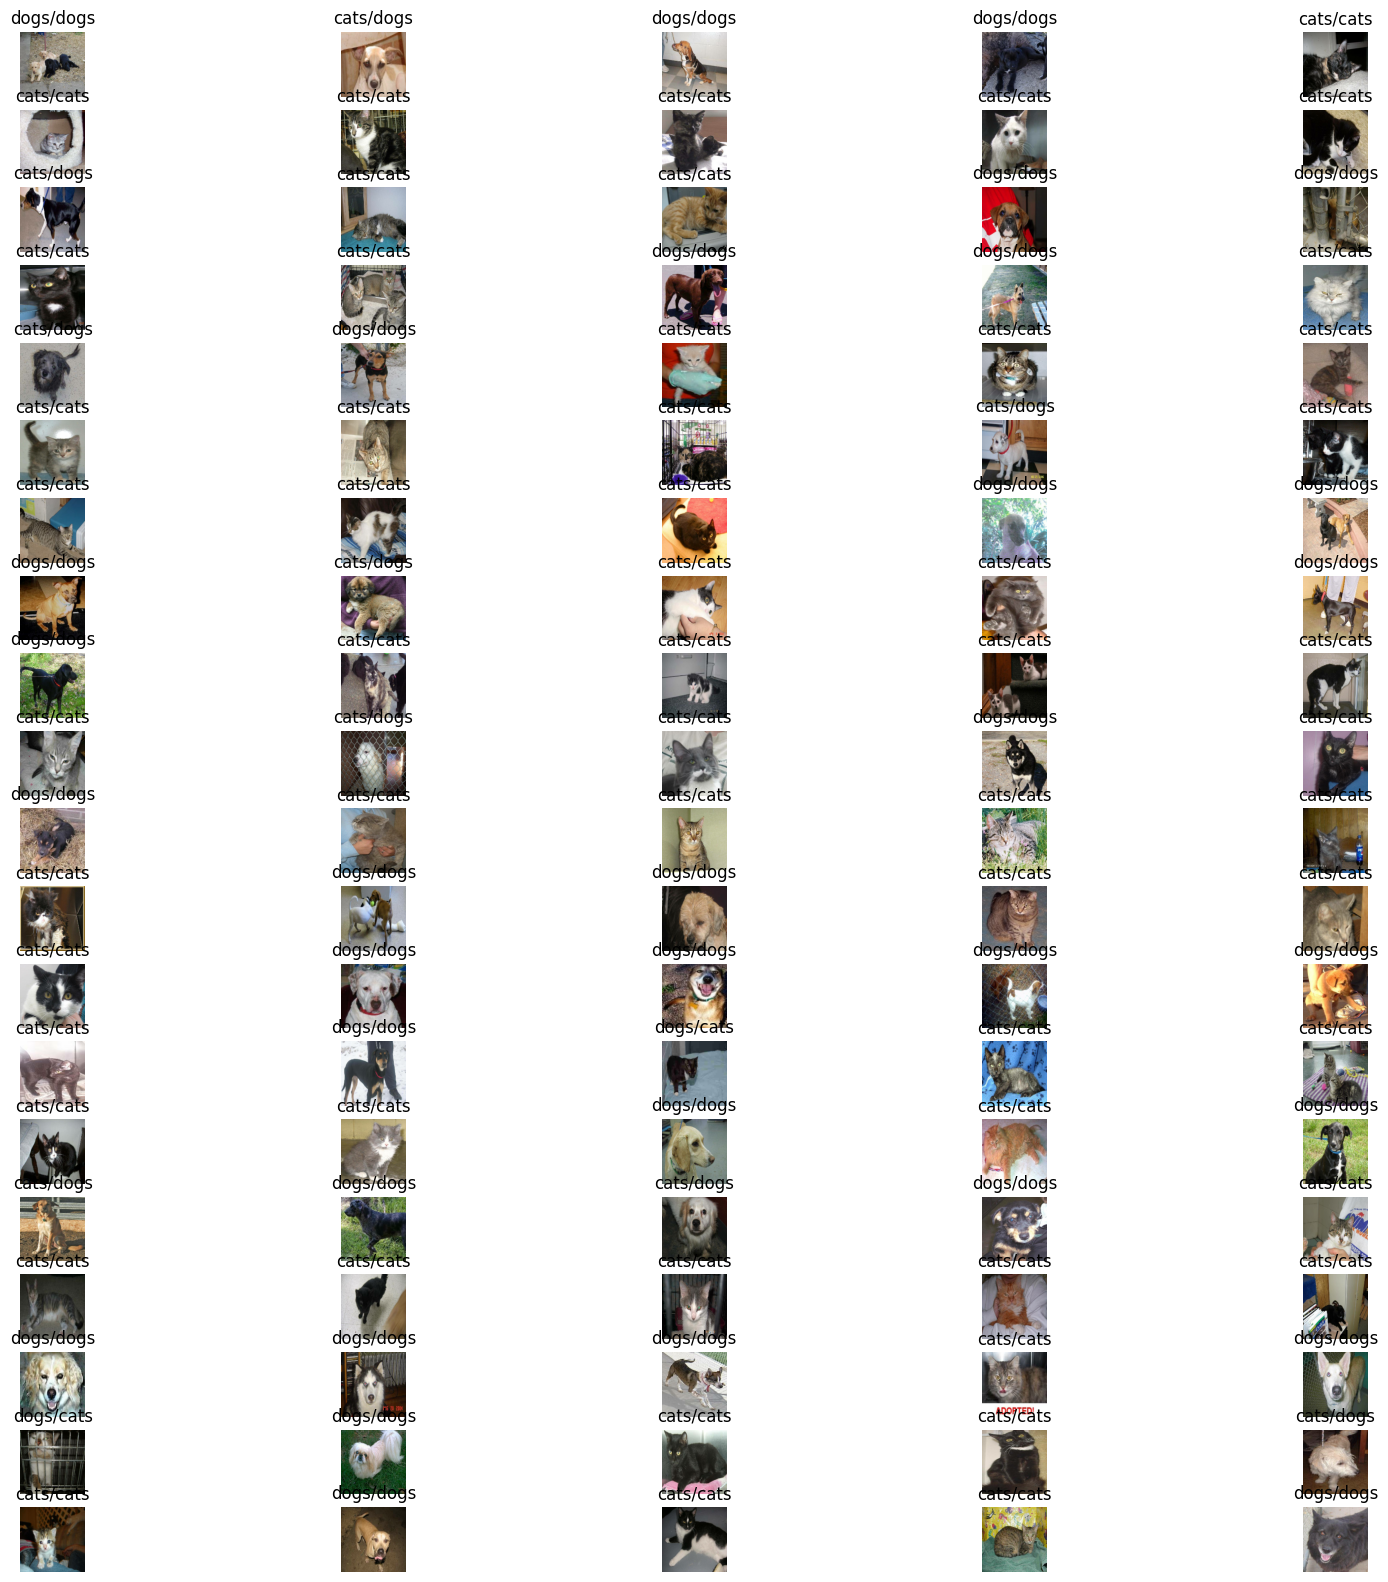

예측 실패 개수: 29


In [56]:
import numpy as np
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

image_batch, label_batch = test_dataset.as_numpy_iterator().next()

logits = model.predict_on_batch(image_batch)
predictions = tf.cast(tf.sigmoid(tf.squeeze(logits)) >= 0.5, tf.int32).numpy()

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(100):
    ax = plt.subplot(20, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{class_names[int(predictions[i])]}/{class_names[int(label_batch[i])]}")
    plt.axis("off")
plt.show()

err = np.sum(predictions != label_batch)
print("예측 실패 개수:", err)

In [57]:
# 2단계: 미세조정

base.trainable = True # 기존 모델 가중치 학습 가능하도록 설정

fine_tune_at = 100
for layer in base.layers[:fine_tune_at]:# 앞에 층은 잘 학습되었으니까 그대로 두고 100층 이후로 학습 시작
    layer.trainable = False # 앞에 층은 그대로 두기

# 모델 컴파
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr/10), # 학습률 줄여서 모델 재구성 -> 미세조정할 때는 크게 학습률 잡으면 가중치 망가짐
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_epochs = 20
model.fit(train_dataset,
          epochs=warm_epochs + fine_epochs, # 최종 epoch = 사전 학습+미세조정
          initial_epoch=history.epoch[-1] + 1, # 사전 학습 끝난 epoch부터 이어서 시작
          validation_data=val_dataset)

Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - accuracy: 0.6091 - loss: 0.6559 - val_accuracy: 0.8275 - val_loss: 0.3418
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.7185 - loss: 0.5554 - val_accuracy: 0.8775 - val_loss: 0.2761
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.7347 - loss: 0.4950 - val_accuracy: 0.9075 - val_loss: 0.2306
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.7897 - loss: 0.4502 - val_accuracy: 0.9175 - val_loss: 0.2013
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.8154 - loss: 0.3954 - val_accuracy: 0.9250 - val_loss: 0.1713
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.8339 - loss: 0.3577 - val_accuracy: 0.9275 - val_loss: 0.1540
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.8336 - loss: 0.3479 - val_accuracy: 0.9388 - val_loss: 0.1345
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.8583 - loss: 0.3149 - val_acc

In [58]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9500 - loss: 0.0761
Test accuracy : 0.949999988079071
<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Predictions:
 [0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0
 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0
 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0
 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0]
Labels:
 [0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0
 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0
 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0
 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0]


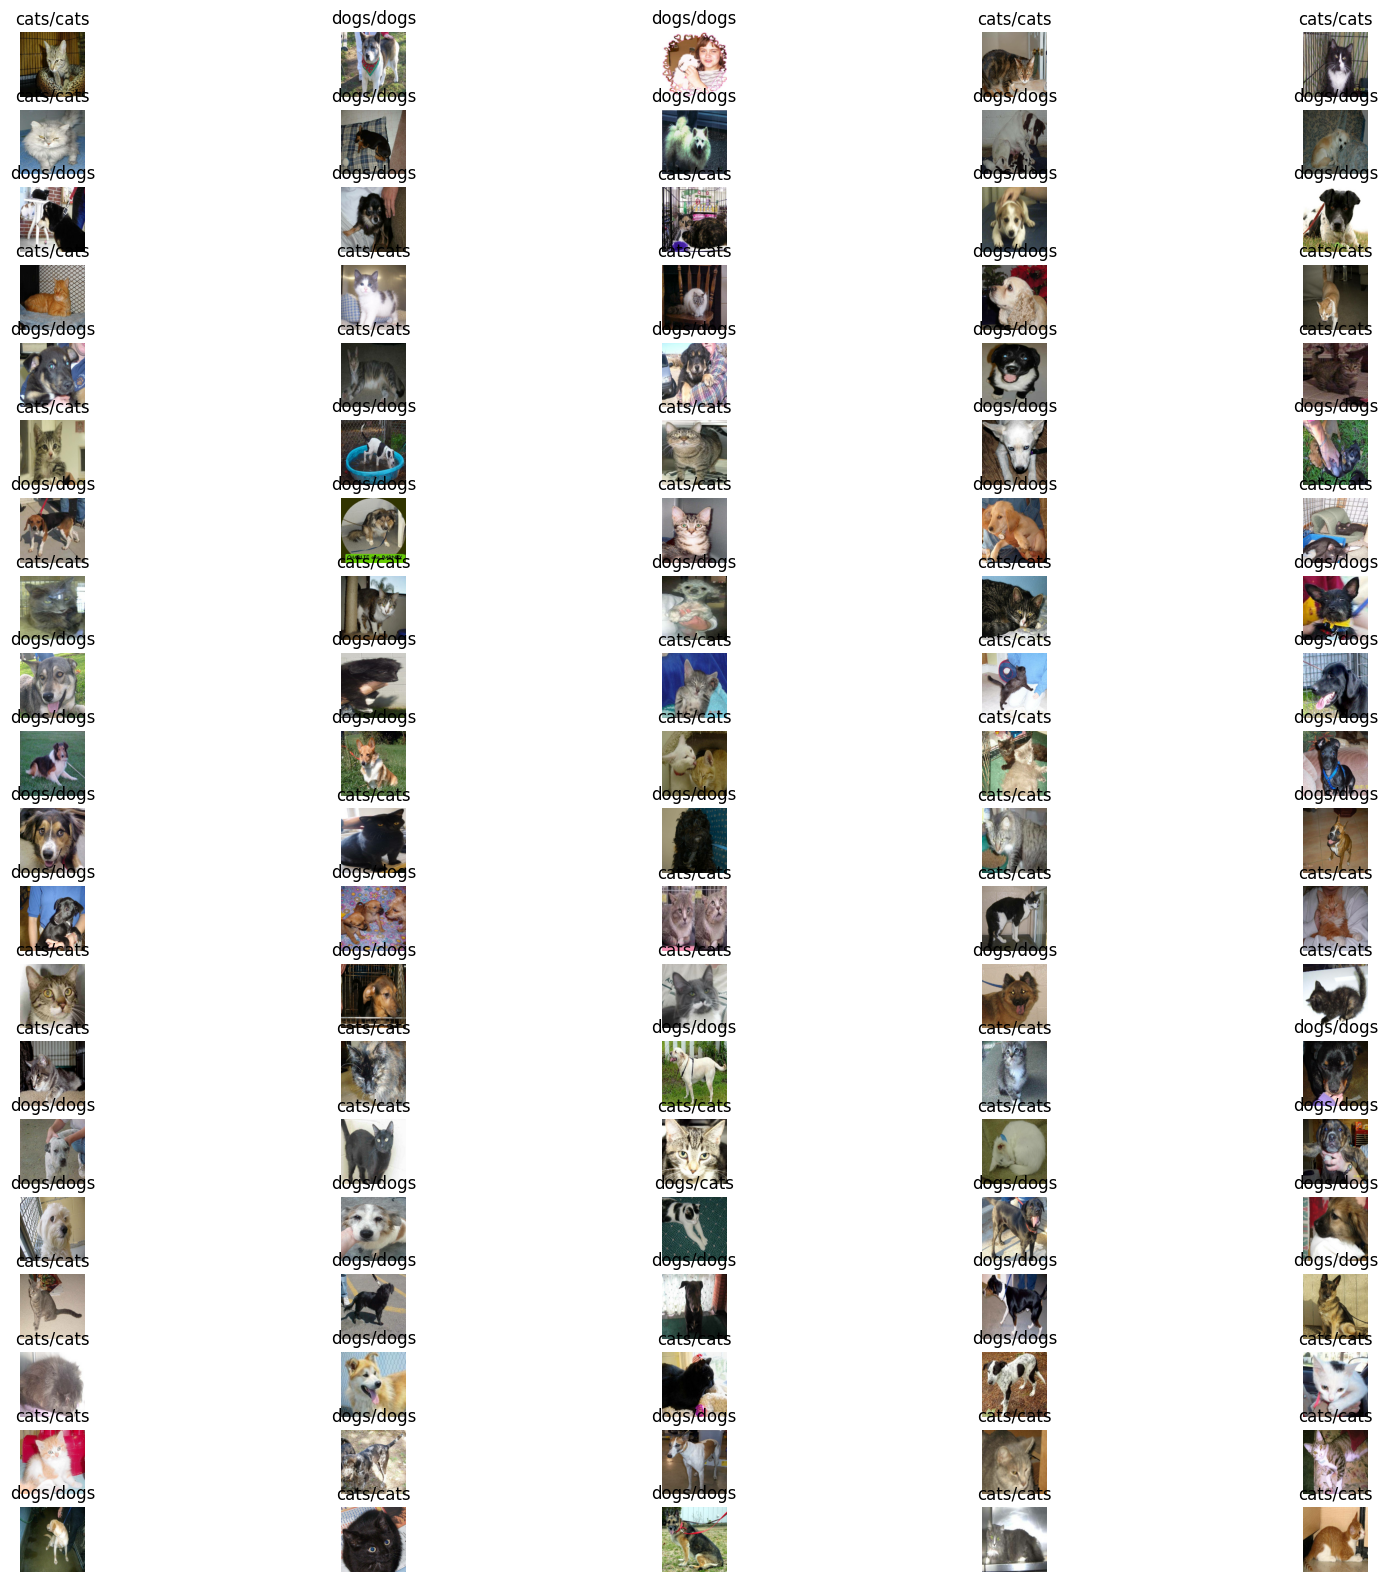

예측 실패 개수: 3


In [59]:
import numpy as np
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

image_batch, label_batch = test_dataset.as_numpy_iterator().next()

logits = model.predict_on_batch(image_batch)
predictions = tf.cast(tf.sigmoid(tf.squeeze(logits)) >= 0.5, tf.int32).numpy()

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(100):
    ax = plt.subplot(20, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"{class_names[int(predictions[i])]}/{class_names[int(label_batch[i])]}")
    plt.axis("off")
plt.show()

err = np.sum(predictions != label_batch)
print("예측 실패 개수:", err)